# Javier Blanco Cordero
Contact: javierblancordero@gmail.com
## causaLens - Code Test
14/06/2020

# 0. Helpers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from statsmodels.tsa import seasonal
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics import tsaplots
from statsmodels.tsa._stl import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet

In [2]:
sns.set()
plt.rcParams['figure.figsize'] = (20, 5)
register_matplotlib_converters()

In [3]:
def month_diff(a, b):
    return 12 * (a.year - b.year) + (a.month - b.month)

def year_diff(a, b):
    return (a.year - b.year)

In [4]:
def plot_AC_and_PAC(series, lags):
    fig, (ax1,ax2) = plt.subplots(1, 2)
    
    tsaplots.plot_acf(series, ax=ax1, lags=lags, alpha=.05)
    ax1.set_title('AC '+series.name)
    
    tsaplots.plot_pacf(series, ax=ax2, lags=lags, alpha=.05)
    ax2.set_title('PAC ' +series.name)
    plt.show()

In [5]:
def plot_residuals_distribution(total_residuals, train_residuals, test_residuals, lags):
    plt.plot(train_residuals.index, train_residuals, color='blue', alpha=.75, label='train')
    plt.plot(test_residuals.index, test_residuals, color='red', alpha=.75, label='test')
    plt.title('Residuals evolution', size=15)
    plt.axvline(train_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.legend()
    plt.show()
    
    fig, (ax1,ax2) = plt.subplots(1, 2)
    tsaplots.plot_acf(train_residuals, ax=ax1, lags=lags, alpha=.05, label='train', color='blue')
    tsaplots.plot_acf(test_residuals, ax=ax1, lags=lags, alpha=.05, label='test', color='red')
    ax1.set_title('Residuals Autocorrelation')
    
    ax2.set_title('Residuals Distribution')
    sns.distplot(train_residuals, ax=ax2, label='train', color='blue')
    sns.distplot(test_residuals, ax=ax2, label='test', color='red')
    plt.axvline(0, color='black', linewidth=1)
    
    plt.legend()
    plt.show()

# 1. Import data
### 1.1 Load data

In [6]:
# Load and check data types
# main_df = pd.read_csv('Data\competitive-data-science-predict-future-sales\sales_train.csv')
# main_df = pd.read_csv('Data\datasets_56102_107707_Electric_Production.csv')
# main_df = pd.read_csv('Data\datasets_56102_107707_daily-minimum-temperatures-in-me.csv')
# main_df = pd.read_csv('Data\datasets_56102_107707_sales-of-shampoo-over-a-three-ye.csv')
# main_df = pd.read_hdf('Data/madrid.h5')
# main_df = pd.read_csv('Data/all_stocks_5yr.csv')

main_df = pd.read_csv('Data/venezia.csv')
display(main_df.head())
main_df.info()

,datetime,level
0,1983-01-01 01:00:00,44.0
1,1983-01-01 02:00:00,35.0
2,1983-01-01 03:00:00,23.0
3,1983-01-01 04:00:00,10.0
4,1983-01-01 05:00:00,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289272 entries, 0 to 289271
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   datetime  289272 non-null  object 
 1   level     289272 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.4+ MB


In [7]:
date_column = 'datetime'
forecast_column = 'level'
features = []

### 2.1 First data checks

In [8]:
# Check available dates and intervals
main_df[date_column].values[:20]

array(['1983-01-01 01:00:00', '1983-01-01 02:00:00',
       '1983-01-01 03:00:00', '1983-01-01 04:00:00',
       '1983-01-01 05:00:00', '1983-01-01 06:00:00',
       '1983-01-01 07:00:00', '1983-01-01 08:00:00',
       '1983-01-01 09:00:00', '1983-01-01 10:00:00',
       '1983-01-01 11:00:00', '1983-01-01 12:00:00',
       '1983-01-01 13:00:00', '1983-01-01 14:00:00',
       '1983-01-01 15:00:00', '1983-01-01 16:00:00',
       '1983-01-01 17:00:00', '1983-01-01 18:00:00',
       '1983-01-01 19:00:00', '1983-01-01 20:00:00'], dtype=object)

In [93]:
"""# Create a date column which has a date format 
main_df[date_column] = pd.date_range(
    start=pd.to_datetime('20100101', format='%Y%m%d'), 
    end=pd.to_datetime('20121201', format='%Y%m%d'), 
    freq='MS') # frecuencies available https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
 main_df.tail()"""

In [22]:
# Count nulls
main_df.isna().sum()

datetime    0
level       0
dtype: int64

In [95]:
# # Solve nulls
# main_df.interpolate(inplace=True) # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
# main_df.head()

In [23]:
# Convert date column into datetime format
main_df[date_column] = pd.to_datetime(main_df[date_column], format='%Y-%m-%d %H', errors='coerce') #'%m/%d/%Y'

# Also, create a DateTimeIndex
main_df.index = pd.DatetimeIndex(main_df[date_column])
main_df.index.name = None

# Use to_numeric in case there´s presence of strings
for column in [forecast_column]+features:
    main_df[column] = pd.to_numeric(main_df[column], errors='coerce')

# Sort data out chronologically
main_df.sort_index(inplace=True)
display(main_df.head())
display(main_df.tail())

,datetime,level
1983-01-01 01:00:00,1983-01-01 01:00:00,44.0
1983-01-01 02:00:00,1983-01-01 02:00:00,35.0
1983-01-01 03:00:00,1983-01-01 03:00:00,23.0
1983-01-01 04:00:00,1983-01-01 04:00:00,10.0
1983-01-01 05:00:00,1983-01-01 05:00:00,1.0


,datetime,level
2015-12-31 20:00:00,2015-12-31 20:00:00,-18.0
2015-12-31 21:00:00,2015-12-31 21:00:00,-14.0
2015-12-31 22:00:00,2015-12-31 22:00:00,-5.0
2015-12-31 23:00:00,2015-12-31 23:00:00,8.0
2016-01-01 00:00:00,2016-01-01 00:00:00,20.0


In [24]:
# Frequency seems daily. Let´s double check
print('dataframe rows: ' + str(len(main_df.index.unique())))

print('days elapsed: ' + str((main_df.index.max() - main_df.index.min()).days*24 + 1))
# print('months elapsed: ' + str(month_diff(main_df.index.max(), main_df.index.min()) + 1))
# print('years elapsed: ' + str(year_diff(main_df.index.max(), main_df.index.min()) + 1))

dataframe rows: 289267
days elapsed: 289249


In [98]:
"""# New index
new_df = pd.DataFrame(
     index = pd.date_range(start=main_df.index.min(), 
                           end=main_df.index.max(), 
                           freq='B') # frecuencies available https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
 )

main_df = pd.merge(new_df, main_df, how='left', left_index=True, right_index=True)
main_df[date_column] = main_df.index
main_df.head()"""

"# New index\nnew_df = pd.DataFrame(\n     index = pd.date_range(start=main_df.index.min(), \n                           end=main_df.index.max(), \n                           freq='B') # frecuencies available https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases\n )\n\nmain_df = pd.merge(new_df, main_df, how='left', left_index=True, right_index=True)\nmain_df[date_column] = main_df.index\nmain_df.head()"

In [99]:
"""missing = main_df.loc[main_df[forecast_column].isna()]
display(missing)"""

'missing = main_df.loc[main_df[forecast_column].isna()]\ndisplay(missing)'

In [100]:
# main_df = main_df.interpolate()
# # main_df = main_df.fillna(method='backfill')
# main_df.isna().sum()

## 1.3 Create log(forecast_column)

In [25]:
main_df['log('+forecast_column+')'] = np.log(main_df[forecast_column])
main_df.head()

/home/alumno/.local/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log

/home/alumno/.local/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning:

invalid value encountered in log



,datetime,level,log(level)
1983-01-01 01:00:00,1983-01-01 01:00:00,44.0,3.784190
1983-01-01 02:00:00,1983-01-01 02:00:00,35.0,3.555348
1983-01-01 03:00:00,1983-01-01 03:00:00,23.0,3.135494
1983-01-01 04:00:00,1983-01-01 04:00:00,10.0,2.302585
1983-01-01 05:00:00,1983-01-01 05:00:00,1.0,0.000000


### 1.3 Group daily data 

In [26]:
"""# monthly_df = main_df.groupby(by=[main_df.index.month, main_df.index.year])[].agg(
# {"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

monthly_sales = main_df.groupby(["date_block_num","shop_id","item_id"]).agg({
    'date': ['min','max'],
    "item_price":"mean",
    "item_cnt_day":"sum"})
monthly_sales.head()"""

'# monthly_df = main_df.groupby(by=[main_df.index.month, main_df.index.year])[].agg(\n# {"date":["min",\'max\'],"item_price":"mean","item_cnt_day":"sum"})\n\nmonthly_sales = main_df.groupby(["date_block_num","shop_id","item_id"]).agg({\n    \'date\': [\'min\',\'max\'],\n    "item_price":"mean",\n    "item_cnt_day":"sum"})\nmonthly_sales.head()'

# 2. EDA

In [27]:
"""ts = main_df.groupby(["date_block_num"])["item_cnt_day"].sum().reset_index()
date_column = 'date_block_num'
forecast_column = 'item_cnt_day'
ts.head()"""

'ts = main_df.groupby(["date_block_num"])["item_cnt_day"].sum().reset_index()\ndate_column = \'date_block_num\'\nforecast_column = \'item_cnt_day\'\nts.head()'

### 2.1 Check time series evolution

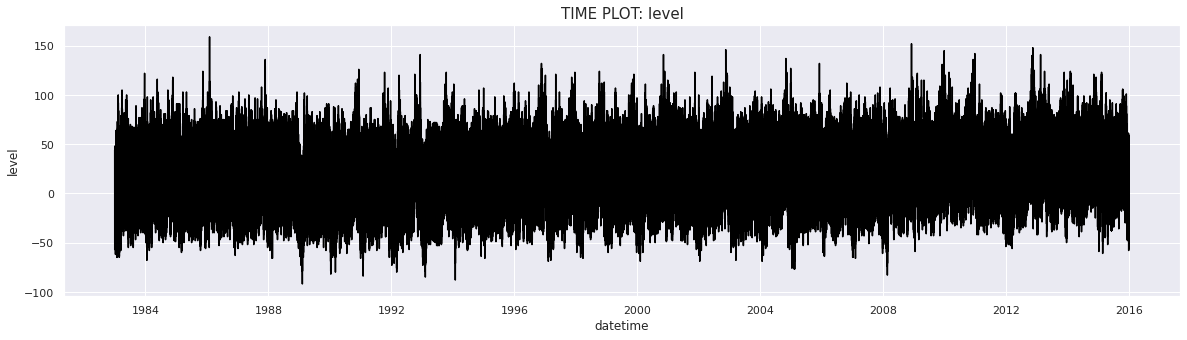

In [28]:
# Time plot: Original 
plt.title('TIME PLOT: '+forecast_column, size=15)
plt.ylabel(forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column], color='black')
plt.plot(main_df[date_column], main_df[forecast_column], color='black')
plt.show()

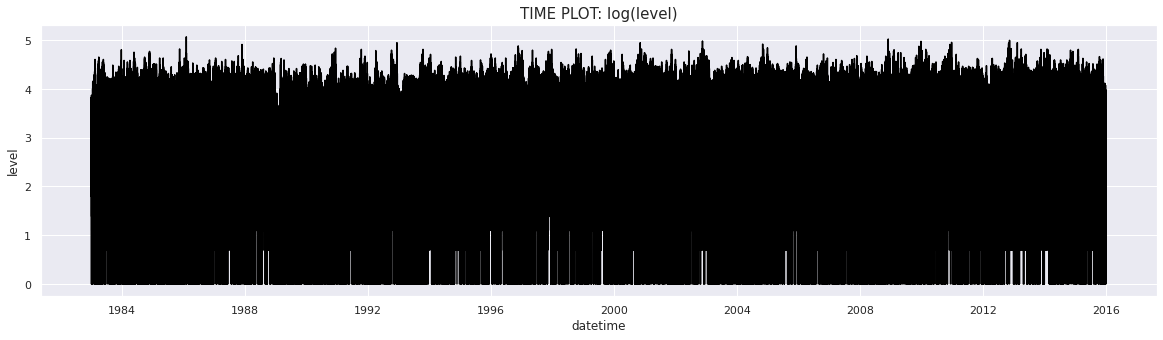

In [29]:
# Time plot: log transformation
plt.title('TIME PLOT: '+'log('+forecast_column+')', size=15)
plt.ylabel(forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column], color='black')
plt.plot(main_df[date_column], main_df['log('+forecast_column+')'], color='black')
plt.show()

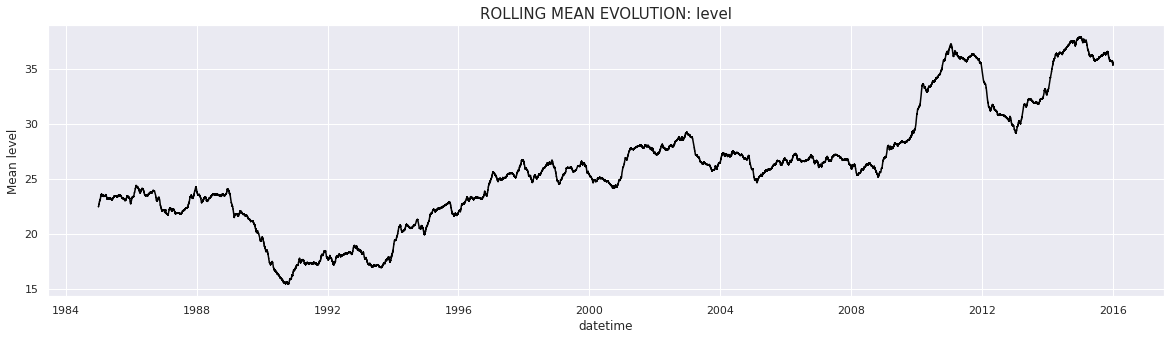

In [31]:
# Mean evolution: original
plt.title('ROLLING MEAN EVOLUTION: '+forecast_column, size=15)
plt.ylabel('Mean '+forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column].rolling(6).mean(), color='black')
plt.plot(main_df[date_column], main_df[forecast_column].rolling(24*365*2).mean(), color='black')
plt.show()

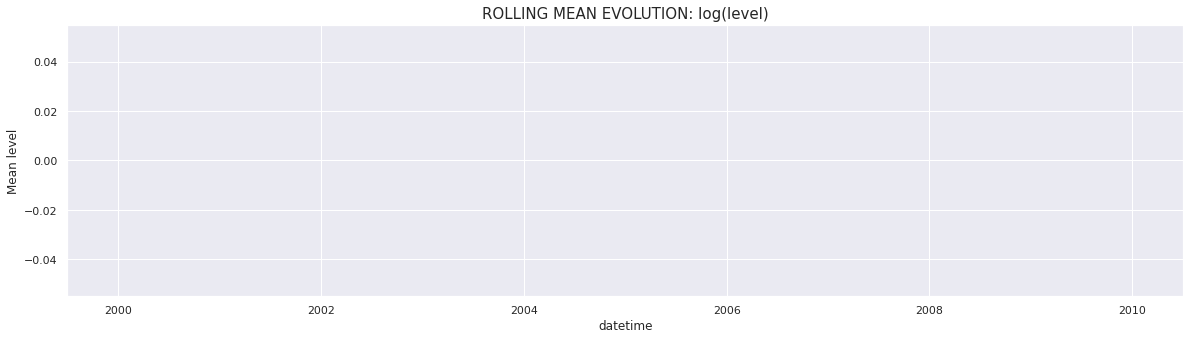

In [32]:
# Mean evolution: log transformation
plt.title('ROLLING MEAN EVOLUTION: '+'log('+forecast_column+')', size=15)
plt.ylabel('Mean '+forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column].rolling(6).mean(), color='black')
plt.plot(main_df[date_column], main_df['log('+forecast_column+')'].rolling(24*365*2).mean(), color='black')
plt.show()

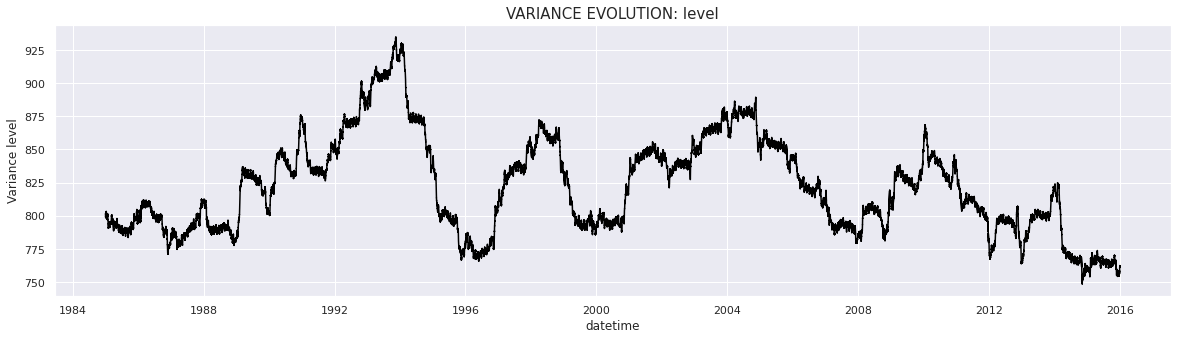

In [33]:
# Deviation evolution: original
plt.title('VARIANCE EVOLUTION: '+forecast_column, size=15)
plt.ylabel('Variance '+forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column].rolling(6).mean(), color='black')
plt.plot(main_df[date_column], main_df[forecast_column].rolling(24*365*2).var(), color='black')
plt.show()

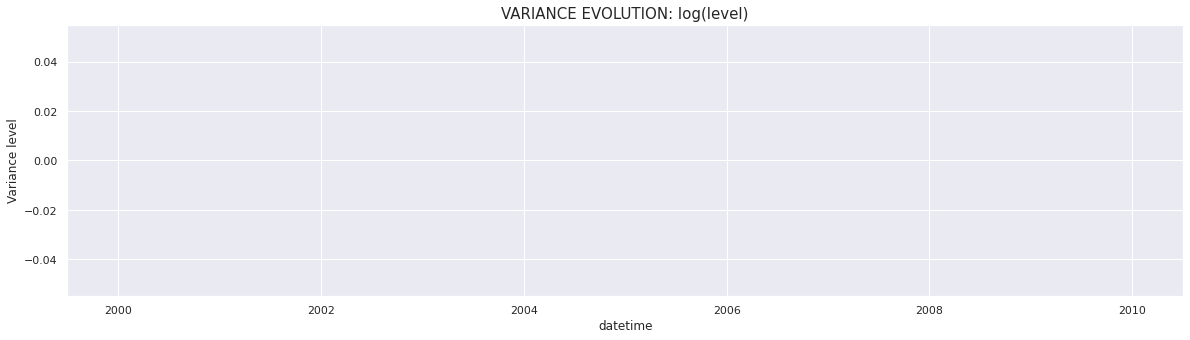

In [34]:
# Deviation evolution: log transformation
plt.title('VARIANCE EVOLUTION: '+'log('+forecast_column+')', size=15)
plt.ylabel('Variance '+forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column].rolling(6).mean(), color='black')
plt.plot(main_df[date_column], main_df['log('+forecast_column+')'].rolling(24*365*2).var(), color='black')
plt.show()

### 2.2 Check seasonal plot

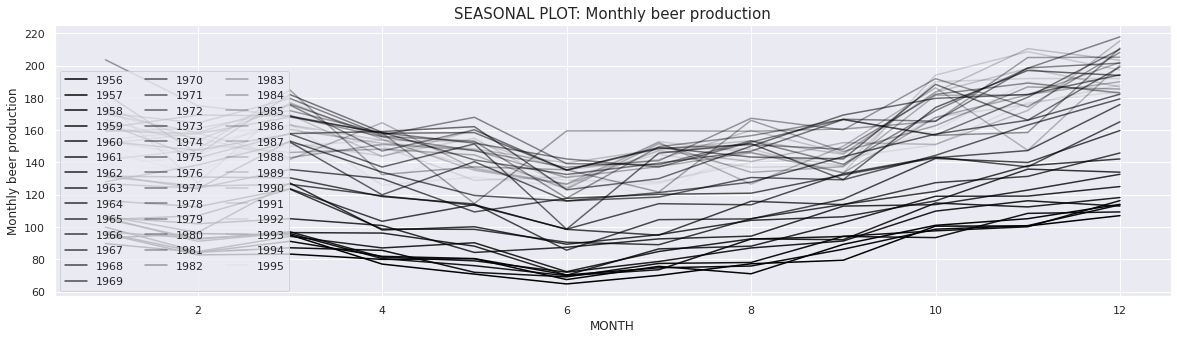

In [110]:
plt.title('SEASONAL PLOT: '+forecast_column, size=15)

years_list = main_df.index.year.unique()
for i, year in enumerate(years_list):
    df_i = main_df.loc[main_df.index.year==year]
    plt.plot(df_i.index.month, df_i[forecast_column], color='black', alpha=(1-i/len(years_list)), label=str(year))
plt.legend(loc="lower left", ncol=3)
plt.ylabel(forecast_column)
plt.xlabel('MONTH')
plt.show()

### 2.4 Autocorrelation

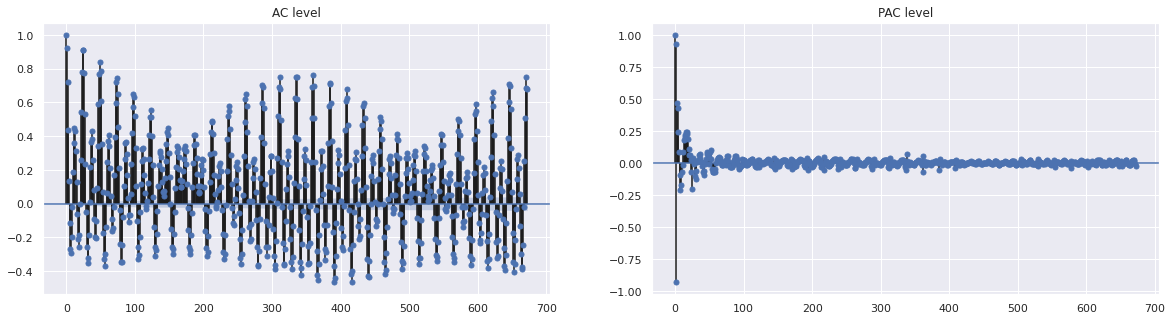

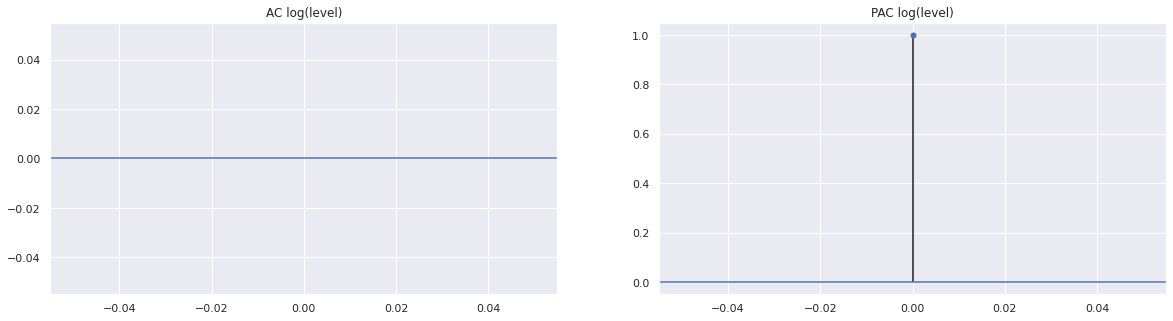

In [35]:
# Autocorrelation and partial autocorrelation
plot_AC_and_PAC(main_df[forecast_column], lags=24*28) # Original
plot_AC_and_PAC(main_df['log('+forecast_column+')'], lags=24*28) # Log transformation

### 2.5 STL Decomposition

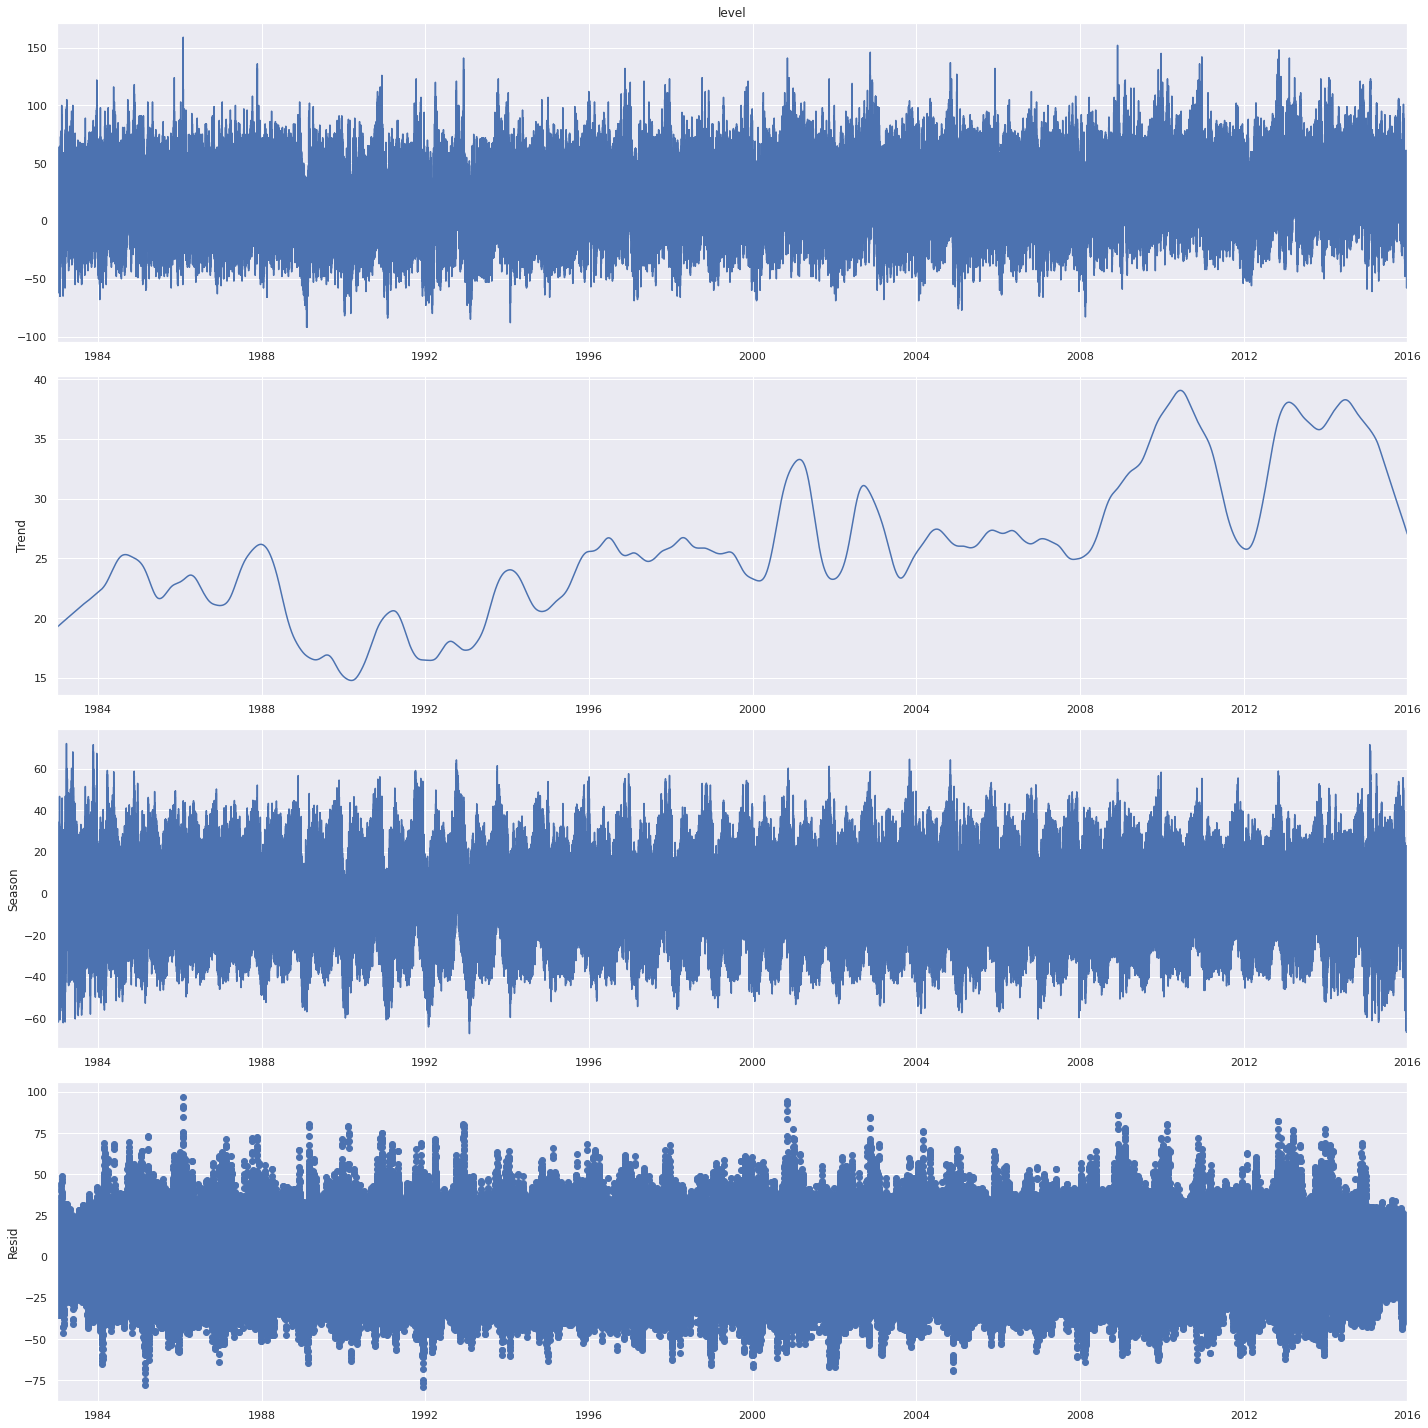

In [36]:
# https://www.statsmodels.org/devel/examples/notebooks/generated/stl_decomposition.html
plt.rcParams['figure.figsize'] = 20,20
res = STL(main_df[forecast_column], period=24*365).fit()
fig = res.plot()
plt.show()
plt.rcParams['figure.figsize'] = (20, 5)

In [114]:
# Strenth of components
# Reference: https://otexts.com/fpp2/seasonal-strength.html
Tt = getattr(res, 'trend') # smoothed trend component
St = getattr(res, 'seasonal') # seasonal component
Rt = getattr(res, 'resid') # remainder component

# Strenth of trend (0 - 1 | small - big trend)
Ft = max(0, 1-(np.var(Rt)/np.var(Tt+Rt)))
print("Strenth of trend: " +str(round(Ft,2)))

# Strenth of seasonality (0 - 1 | small - big seasonality)
Fs = max(0, 1-(np.var(Rt)/np.var(St+Rt)))
print("Strenth of seasonality: " +str(round(Fs,2)))

Strenth of trend: 0.95
Strenth of seasonality: 0.87


# Data Transformations

## kpss test
Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html

In [115]:
kpss(main_df[forecast_column], 
     regression = 'c',    # stationary around a constant ‘c’ or a trend ‘ct’
     nlags = 'auto')

/home/alumno/anaconda3/envs/mmm/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning:

p-value is smaller than the indicated p-value



(2.965464347983591,
 0.01,
 12,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

## .1 Differenciation

In [116]:
lags = 12

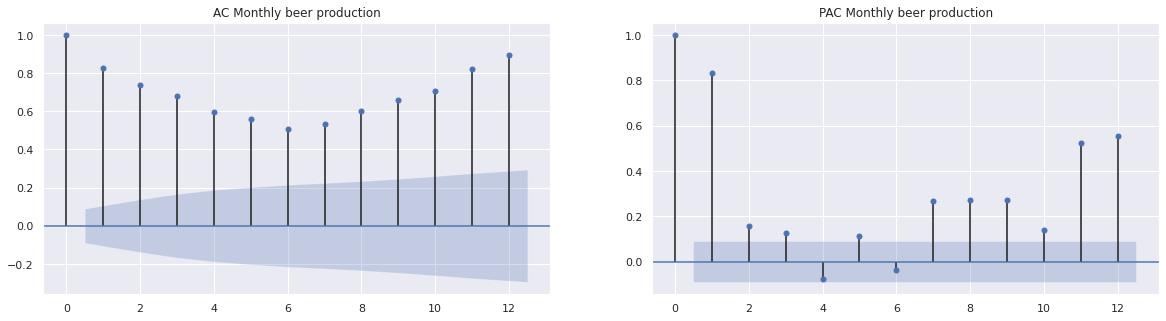

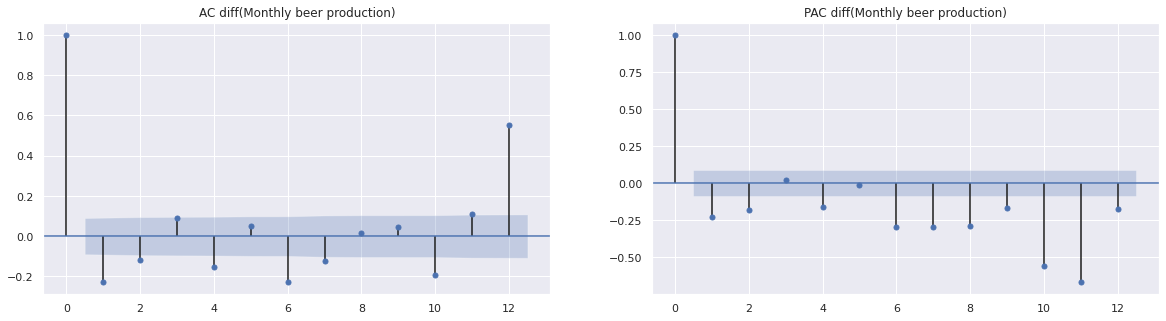

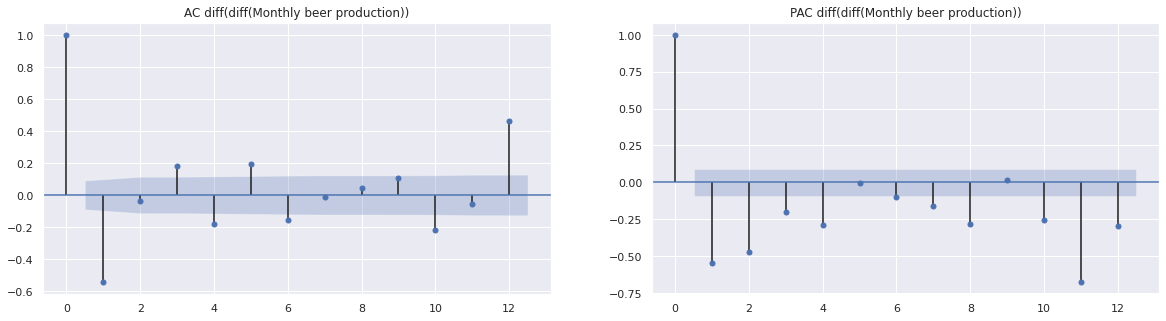

In [117]:
# https://otexts.com/fpp2/stationarity.html

# First order differencing
main_df['diff('+forecast_column+')'] = main_df[forecast_column] - main_df[forecast_column].shift(1)

# Second order differencing
main_df['diff(diff('+forecast_column+'))'] = main_df['diff('+forecast_column+')'] - (main_df[forecast_column].shift(1) - main_df[forecast_column].shift(2))


# Plotting
plot_AC_and_PAC(main_df[forecast_column], lags) # Original
plot_AC_and_PAC(main_df['diff('+forecast_column+')'].dropna(), lags) # First differencing
plot_AC_and_PAC(main_df['diff(diff('+forecast_column+'))'].dropna(), lags) # Second order differencing

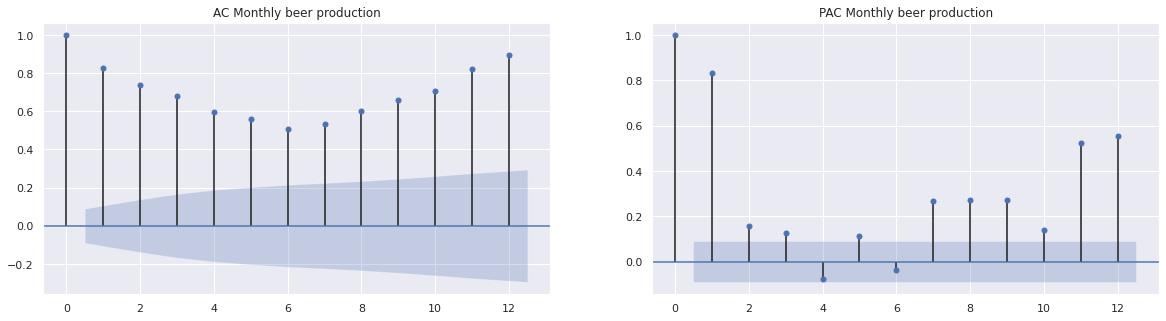

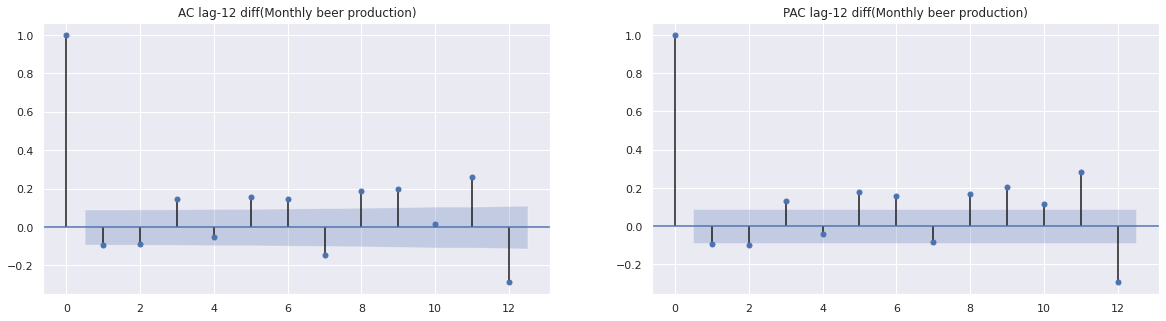

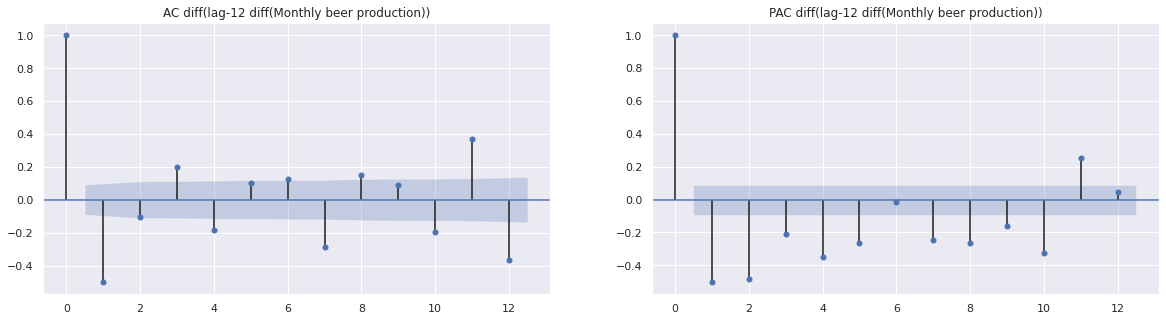

In [118]:
# https://otexts.com/fpp2/stationarity.html

# Seasonal differencing
main_df['lag-12 diff('+forecast_column+')'] = main_df[forecast_column] - main_df[forecast_column].shift(12)

# Second order differencing
main_df['diff(lag-12 diff('+forecast_column+'))'] = main_df['lag-12 diff('+forecast_column+')'] - (main_df[forecast_column].shift(1)-main_df[forecast_column].shift(13))

# Plotting
plot_AC_and_PAC(main_df[forecast_column], lags) # Original
plot_AC_and_PAC(main_df['lag-12 diff('+forecast_column+')'].dropna(), lags) # Seasonal differencing
plot_AC_and_PAC(main_df['diff(lag-12 diff('+forecast_column+'))'].dropna(), lags) # Seasonal differencing with further differencing

# 3 Model Fit

## 3.1 Train-test split

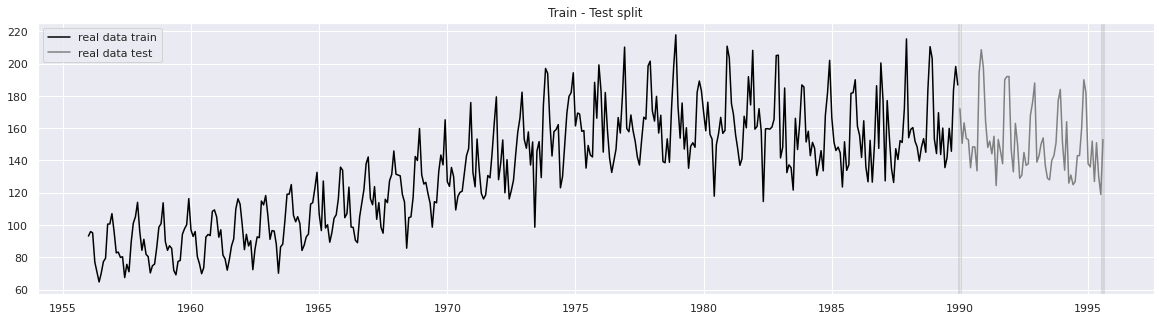

In [119]:
separating_date = pd.to_datetime('19900101', format='%Y%m%d')
train_df = main_df.loc[main_df.index < separating_date]
test_df = main_df.loc[main_df.index >= separating_date]

# final_forecasting_date = pd.to_datetime('20200101', format='%Y%m%d')
# forecast_df = pd.DataFrame(
#     index = pd.date_range(start = main_df.index.max(), 
#                           end = final_forecasting_date, 
#                           freq='MS', closed='right') # frecuencies available https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
# )


# Visualise train test split
plt.title('Train - Test split')
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
plt.axvline(separating_date, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()

## 3.2 Exponential Smoothing

In [120]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html
ES = ExponentialSmoothing(train_df[forecast_column], 
                          trend = 'multiplicative',  #  {“additive”, “multiplicative”, None}
                          seasonal = 'multiplicative', #{“additive”, “multiplicative”, None}
                          seasonal_periods = 12,
                          damped = True).fit()

y_test_pred = ES.predict(start=test_df.index[0], end=test_df.index[-1])
y_train_pred = ES.predict(start=train_df.index[0], end=train_df.index[-1])
y_all_pred = ES.predict(start=train_df.index[0], end=test_df.index[-1])

/home/alumno/anaconda3/envs/mmm/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



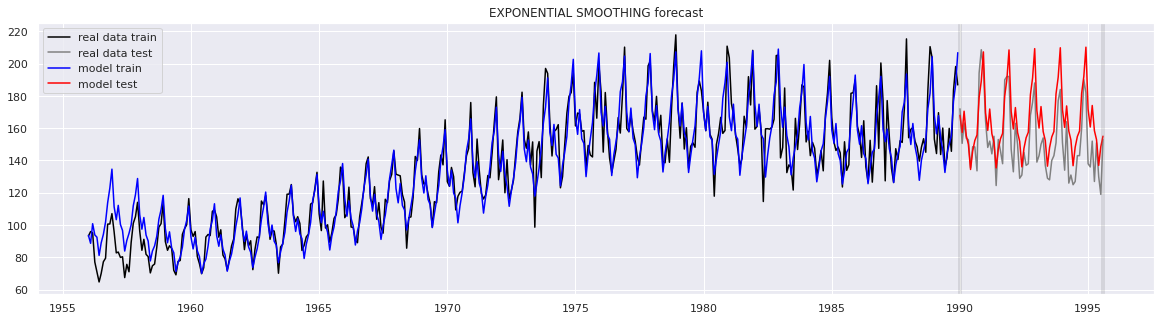

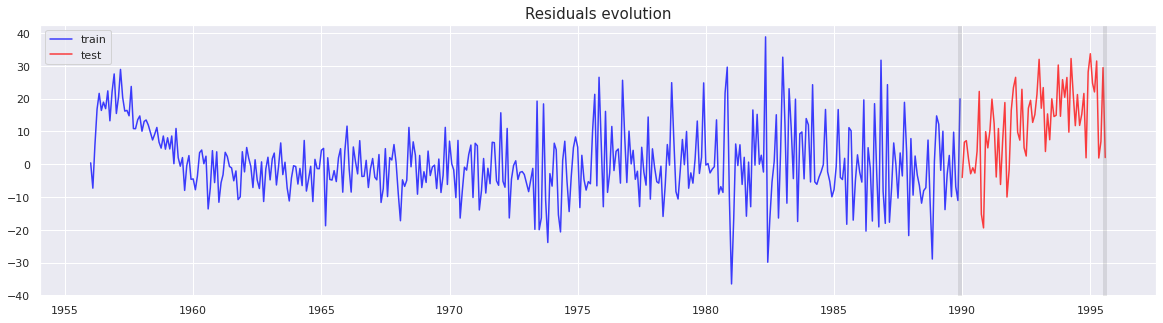

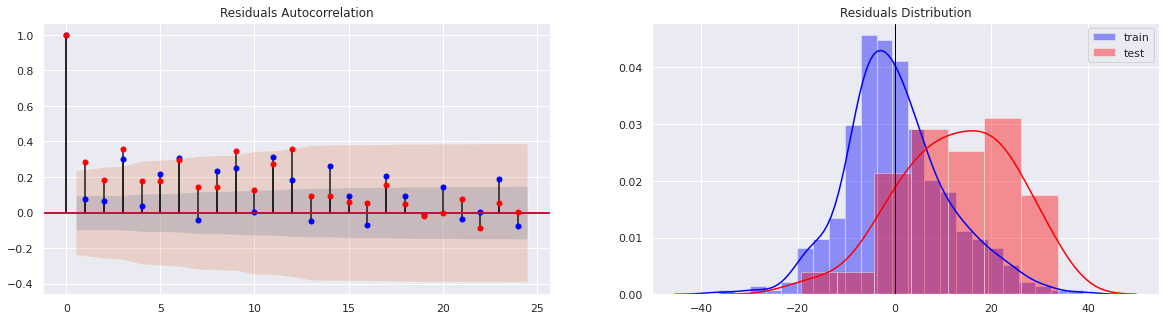

In [121]:
# PLOT

# Visualise forecast
plt.title('EXPONENTIAL SMOOTHING forecast')
# Real data
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
# Model
plt.plot(train_df.index, y_train_pred, color='blue', label='model train')
plt.plot(test_df.index, y_test_pred, color='red', label='model test')
# Test reference lines
plt.axvline(separating_date, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()


# Plot residuals
residuals_train = y_train_pred - train_df[forecast_column]
errors_test = y_test_pred - test_df[forecast_column]
residuales_totales = y_all_pred - main_df[forecast_column]
plot_residuals_distribution(residuales_totales, residuals_train, errors_test, 24)

In [128]:
evaluation = pd.DataFrame({'Metrics': ['MAPE', 'MSE', 'R2'],
                           'Train': [np.mean(np.abs(train_df[forecast_column] - y_train_pred) / train_df[forecast_column]), 
                                     np.sqrt(((y_train_pred - train_df[forecast_column]) ** 2).mean()), 
                                     r2_score(train_df[forecast_column], y_train_pred)], 
                           'Test': [np.mean(np.abs(test_df[forecast_column] - y_test_pred) / test_df[forecast_column]), 
                                     np.sqrt(((y_test_pred - test_df[forecast_column]) ** 2).mean()), 
                                     r2_score(test_df[forecast_column], y_test_pred)]
                          })

evaluation['Degradation (%)'] = round(100*(evaluation['Test']-evaluation['Train'])/evaluation['Train'],2)
evaluation

,Metrics,Train,Test,Degradation (%)
0,MAPE,0.064711,0.100461,55.25
1,MSE,10.740750,17.305478,61.12
2,R2,0.904371,0.315961,-65.06


## 3.3 ARIMA

In [137]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html
ARIMA_model = ARIMA(train_df[forecast_column], 
                    order=(13,1,0)).fit()
y_test_pred = ARIMA_model.predict(start=test_df.index[0], end=test_df.index[-1], typ='levels')
y_train_pred = ARIMA_model.predict(start=train_df.index[15], end=train_df.index[-1], typ='levels')
y_all_pred = ARIMA_model.predict(start=train_df.index[15], end=test_df.index[-1], typ='levels')

/home/alumno/anaconda3/envs/mmm/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/alumno/anaconda3/envs/mmm/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



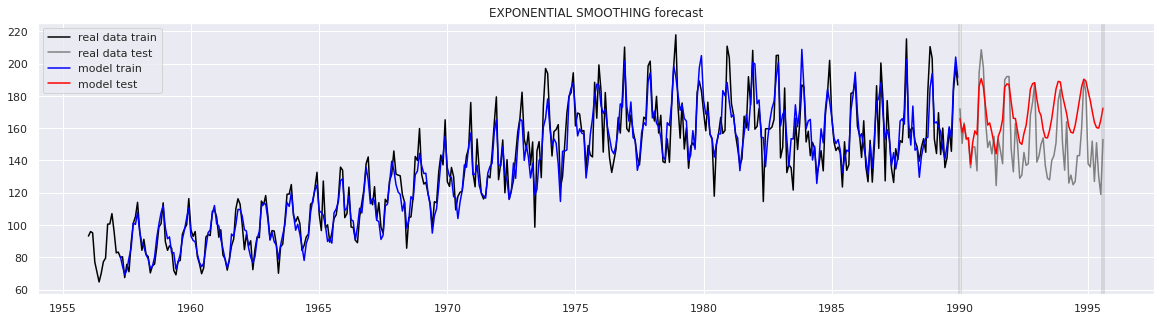

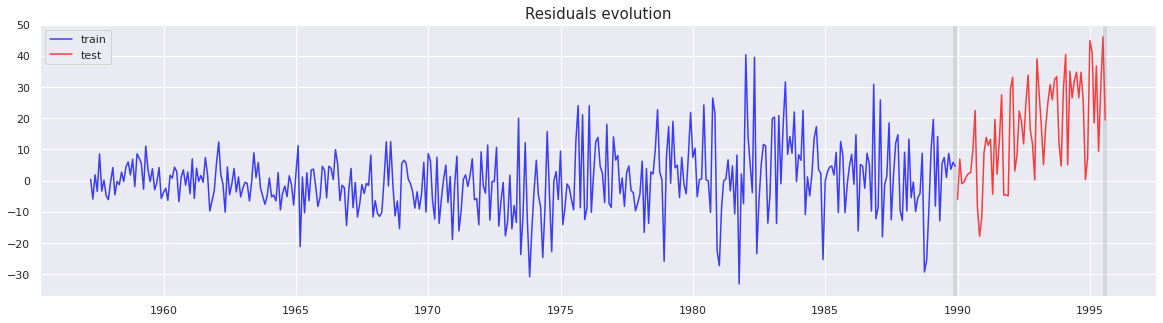

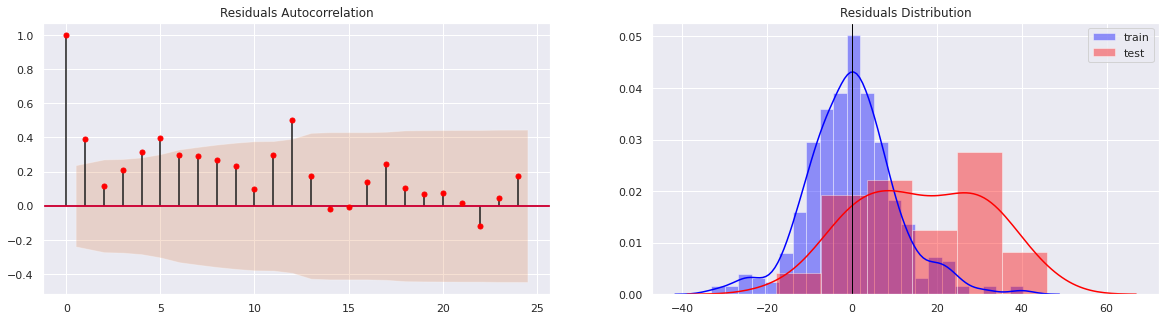

In [138]:
# PLOT

# Visualise forecast
plt.title('EXPONENTIAL SMOOTHING forecast')
# Real data
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
# Model
plt.plot(y_train_pred.index, y_train_pred, color='blue', label='model train')
plt.plot(y_test_pred.index, y_test_pred, color='red', label='model test')
# Test reference lines
plt.axvline(separating_date, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()


# Plot residuals
residuals_train = y_train_pred - train_df[forecast_column]
errors_test = y_test_pred - test_df[forecast_column]
residuales_totales = y_all_pred - main_df[forecast_column]
plot_residuals_distribution(residuales_totales, residuals_train, errors_test, 24)

In [146]:
evaluation = pd.DataFrame({'Metrics': ['MAPE', 'MSE', 'R2'],
                           'Train': [np.mean(np.abs(train_df[forecast_column][-len(y_train_pred):] - y_train_pred) / train_df[forecast_column][-len(y_train_pred):]), 
                                     np.sqrt(((y_train_pred - train_df[forecast_column][-len(y_train_pred):]) ** 2).mean()), 
                                     r2_score(train_df[forecast_column][-len(y_train_pred):], y_train_pred)], 
                           'Test': [np.mean(np.abs(test_df[forecast_column][-len(y_test_pred):] - y_test_pred) / test_df[forecast_column][-len(y_test_pred):]), 
                                     np.sqrt(((y_test_pred - test_df[forecast_column][-len(y_test_pred):]) ** 2).mean()), 
                                     r2_score(test_df[forecast_column][-len(y_test_pred):],y_test_pred)]
                          })

evaluation['Degradation (%)'] = round(100*(evaluation['Test']-evaluation['Train'])/evaluation['Train'],2)
evaluation

,Metrics,Train,Test,Degradation (%)
0,MAPE,0.056947,0.130234,128.69
1,MSE,10.535408,22.368273,112.32
2,R2,0.904057,-0.142823,-115.80


## 3.5 Prophet

In [131]:
train_prophet = train_df[forecast_column].reset_index()
train_prophet.columns = ['ds','y']
test_prophet = test_df[forecast_column].reset_index()
test_prophet.columns = ['ds','y']

# Prophet https://facebook.github.io/prophet/docs/
m = Prophet(seasonality_mode='multiplicative', #seasonality_mode='multiplicative' or 'additive'
            interval_width=0.95,
            yearly_seasonality = True,
            #growth='logistic')
           )

# https://stackoverflow.com/questions/47534553/how-to-extract-seasonal-trends-from-prophet
#m.add_seasonality(name='weekly', period=7, fourier_order=3)

m.fit(train_prophet)

forecast_train = m.predict(train_prophet)
forecast_test = m.predict(test_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [132]:
y_train_pred = forecast_train[['ds','yhat']].set_index('ds',drop=True)
y_train_pred.index.name = None
y_train_pred = y_train_pred['yhat']

y_test_pred = forecast_test[['ds','yhat']].set_index('ds',drop=True)
y_test_pred.index.name = None
y_test_pred = y_test_pred['yhat']

y_all_pred = y_train_pred.append(y_test_pred)

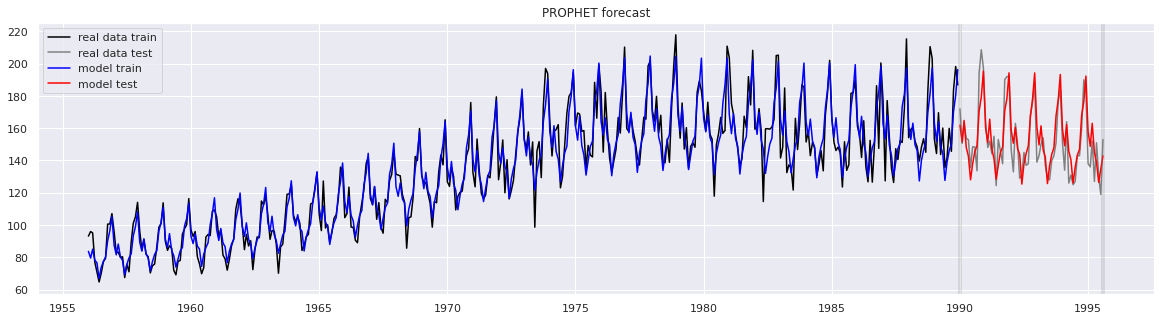

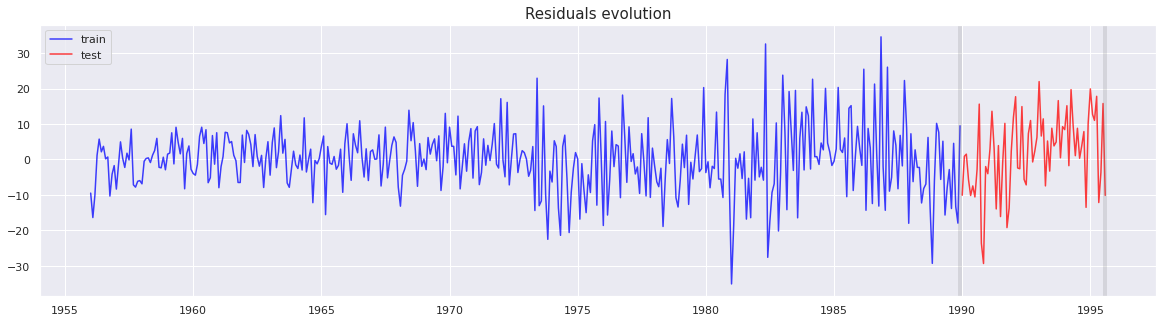

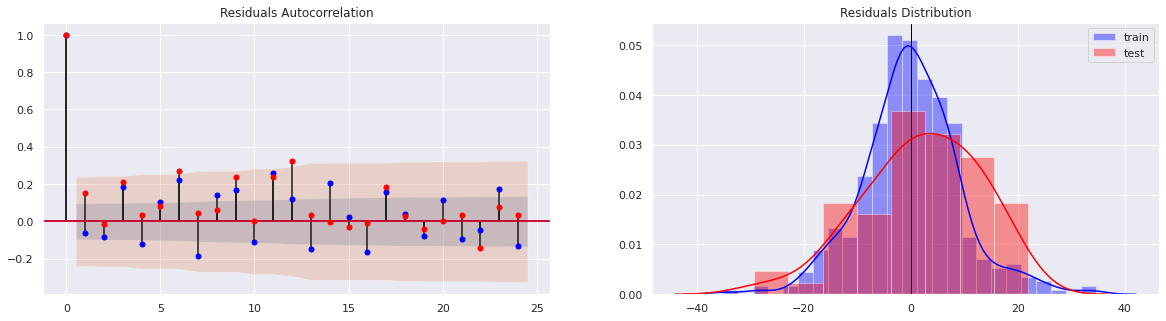

In [133]:
# PLOT

# Visualise forecast
plt.title('PROPHET forecast')
# Real data
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
# Model
plt.plot(y_train_pred.index, y_train_pred, color='blue', label='model train')
plt.plot(y_test_pred.index, y_test_pred, color='red', label='model test')
# Test reference lines
plt.axvline(separating_date, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()


# Plot residuals
residuals_train = y_train_pred - train_df[forecast_column]
errors_test = y_test_pred - test_df[forecast_column]
residuales_totales = y_all_pred - main_df[forecast_column]
plot_residuals_distribution(residuales_totales, residuals_train, errors_test, 24)

In [134]:
evaluation = pd.DataFrame({'Metrics': ['MAPE', 'MSE', 'R2'],
                           'Train': [np.mean(np.abs(train_df[forecast_column] - y_train_pred) / train_df[forecast_column]), 
                                     np.sqrt(((y_train_pred - train_df[forecast_column]) ** 2).mean()), 
                                     r2_score(train_df[forecast_column], y_train_pred)], 
                           'Test': [np.mean(np.abs(test_df[forecast_column] - y_test_pred) / test_df[forecast_column]), 
                                     np.sqrt(((y_test_pred - test_df[forecast_column]) ** 2).mean()), 
                                     r2_score(test_df[forecast_column], y_test_pred)]
                          })

evaluation['Degradation (%)'] = round(100*(evaluation['Test']-evaluation['Train'])/evaluation['Train'],2)
evaluation

,Metrics,Train,Test,Degradation (%)
0,MAPE,0.051732,0.060732,17.40
1,MSE,9.265387,11.104023,19.84
2,R2,0.928838,0.718373,-22.66
